In [ ]:
# Instalar las librerías necesarias
!pip install transformers torch scikit-learn

In [81]:
import os

# Ruta correcta donde están los archivos .txt
data_path = "/content/drive/MyDrive/documentosTokens"  # Cambia esta ruta a la correcta

# Definir las 5 categorías (puedes ajustar los nombres según sea necesario)
categories = {
    "reglamentos_academicos": 0,
    "reglamentos_administrativos": 1,
    "reglamentos_laboratorio": 2,
    "reglamentos_estudiantiles": 3,
    "otros": 4

# Cargar documentos y asignar etiquetas
texts = []
labels = []

# Cargar los archivos desde la carpeta
documents = [f for f in os.listdir(data_path) if f.endswith(".txt")]

for file_name in documents:
    file_path = os.path.join(data_path, file_name) #contruye la ruta con la direc y nombre
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read()
    except UnicodeDecodeError:
        # Si ocurre un error, intenta con una codificación diferente (por ejemplo, ISO-8859-1)
        with open(file_path, "r", encoding="ISO-8859-1") as file:
            content = file.read()

    texts.append(content)

    # Asignar etiquetas basadas en el nombre del archivo
    if "ACADEMICO" in file_name.upper() or "POLITICAS" in file_name.upper():
        labels.append(categories["reglamentos_academicos"])
    elif "ADMINISTRATIVA" in file_name.upper() or "INTERNO" in file_name.upper():
        labels.append(categories["reglamentos_administrativos"])
    elif "LABORATORIO" in file_name.upper():
        labels.append(categories["reglamentos_laboratorio"])
    elif "ESTUDIANTIL" in file_name.upper() or "RÉGIMEN" in file_name.upper():
        labels.append(categories["reglamentos_estudiantiles"])
    else:
        labels.append(categories["otros"])  # Categoría "otros" para documentos no clasificados

# Comprobar cuántos documentos y etiquetas se cargaron
print(f"Documentos cargados: {len(texts)}")
print(f"Etiquetas asignadas: {len(labels)}")




Documentos cargados: 24
Etiquetas asignadas: 24


In [82]:
from sklearn.model_selection import train_test_split

# Dividir los datos en 80% para entrenamiento y 20% para prueba
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

print(f"Datos de entrenamiento: {len(train_texts)}")
print(f"Datos de prueba: {len(test_texts)}")


Datos de entrenamiento: 19
Datos de prueba: 5


In [83]:
from transformers import AutoTokenizer

# Elegir un modelo preentrenado (puedes cambiarlo si lo deseas)
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name) #Se carga el tokenizador asociado con el modelo preentrenado esp

# Función para tokenizar textos
def tokenize_data(texts):
    return tokenizer(
        texts,
        padding=True,  # Agregar ceros para que todos los textos tengan la misma longitud
        truncation=True,  # Recortar textos demasiado largos
        max_length=512,  # Longitud máxima de 512 tokens (como recomienda BERT)
        return_tensors="pt",  # Regresar tensores PyTorch
        return_token_type_ids=False
    )

# Tokenizar textos de entrenamiento y prueba
train_encodings = tokenize_data(train_texts)
test_encodings = tokenize_data(test_texts)


In [84]:
import torch
from torch.utils.data import Dataset

# Crear un Dataset personalizado
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Crear los datasets de entrenamiento y prueba
train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)


In [85]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch.nn as nn
#construyendo un modelo de clasificación de secuencias utilizando BERT
#modelo de BERT para clasificar textos
class CustomBERTModel(nn.Module):
    def __init__(self, model_name, num_labels, dropout_prob=0.1):
        super(CustomBERTModel, self).__init__()

        # Cargar la configuración del modelo preentrenado
        config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)

        # Actualizar la probabilidad de dropout en la configuración
        config.hidden_dropout_prob = dropout_prob  # Aplicar dropout a la capa oculta
        config.attention_probs_dropout_prob = dropout_prob  # Aplicar dropout a la capa de atención

        # Crear el modelo con la configuración modificada
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

    def forward(self, input_ids, attention_mask, labels=None):

      # Llama al modelo BERT con los inputs (ids de palabras, máscara de atención y etiquetas)
      return self.bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)


In [86]:
model = CustomBERTModel(model_name="bert-base-uncased", num_labels=len(categories), dropout_prob=0.25)  # Ejemplo con dropout de 0.2

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
# #DEFINIR EL MODELO
# from transformers import AutoModelForSequenceClassification

# #Cargar el modelo preentrenado con el número de categorías de nuestro dataset
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_name,
#     num_labels=len(categories)
# )


In [88]:
#configurar el entrenamiento

from transformers import AdamW, get_scheduler
from torch.utils.data import DataLoader

# Configurar DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

# Definir el optimizador
optimizer = AdamW(model.parameters(), lr=0.00003)

# Configurar scheduler para ajustar la tasa de aprendizaje
num_training_steps = len(train_loader) * 3  # 3 épocas
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Usar GPU si está disponible
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


CustomBERTModel(
  (bert): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.25, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.25, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feature

In [89]:
#entrenar el modelo

from sklearn.metrics import accuracy_score

train_losses = []
val_accuracies = []
# Entrenar el modelo
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    # Fase de entrenamiento
    model.train() # Configura el modelo en modo de entrenamiento (activa dropout, etc.)
    total_loss = 0
    for batch in train_loader: # Procesa cada lote de datos de entrenamiento
        batch = {k: v.to(device) for k, v in batch.items()}  #Mueve el batch a la GPU o CPU
        outputs = model(**batch) # Realiza la pasada hacia adelante
        loss = outputs.loss # Obtiene la pérdida del modelo
        total_loss += loss.item() # Suma la pérdida de este lote

        optimizer.zero_grad() # Limpia los gradientes del optimizador
        loss.backward() # Realiza la retropropagación (calcula los gradientes)
        optimizer.step() # Actualiza los parámetros del modelo

    #print(f"Loss: {total_loss / len(train_loader)}")
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  # Almacenar la pérdida promedio por época
    print(f"Loss: {avg_loss}")

    # Fase de validación
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad(): # Desactiva el cálculo de gradientes (ahorra memoria y tiempo)
        for batch in test_loader: # Procesa cada lote de datos de entrenamiento
            batch = {k: v.to(device) for k, v in batch.items()} # Mueve el batch a la GPU o CPU
            outputs = model(**batch) # Realiza la pasada hacia adelante
            predictions = torch.argmax(outputs.logits, dim=-1) # Obtiene la clase con la probabilidad más alta
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    val_accuracies.append(accuracy)  # Almacenar precisión por época
    print(f"Validation Accuracy: {accuracy}")


Epoch 1
Loss: 1.3853998184204102
Validation Accuracy: 0.8
Epoch 2
Loss: 0.9887313842773438
Validation Accuracy: 0.8
Epoch 3
Loss: 0.8491790175437928
Validation Accuracy: 0.8
Epoch 4
Loss: 0.6796955645084382
Validation Accuracy: 0.8
Epoch 5
Loss: 0.6000987231731415
Validation Accuracy: 0.8
Epoch 6
Loss: 0.6358363509178162
Validation Accuracy: 0.8
Epoch 7
Loss: 0.6803507804870605
Validation Accuracy: 0.8
Epoch 8
Loss: 0.5148951858282089
Validation Accuracy: 0.8
Epoch 9
Loss: 0.5269124507904053
Validation Accuracy: 0.8
Epoch 10
Loss: 0.5172101348638535
Validation Accuracy: 0.8
Epoch 11
Loss: 0.5286088317632676
Validation Accuracy: 0.8
Epoch 12
Loss: 0.528037479519844
Validation Accuracy: 0.8
Epoch 13
Loss: 0.5496161073446274
Validation Accuracy: 0.8
Epoch 14
Loss: 0.45488059222698213
Validation Accuracy: 0.8
Epoch 15
Loss: 0.42714746594429015
Validation Accuracy: 0.8
Epoch 16
Loss: 0.5567925930023193
Validation Accuracy: 0.8
Epoch 17
Loss: 0.5504615724086761
Validation Accuracy: 0.8
Epoch

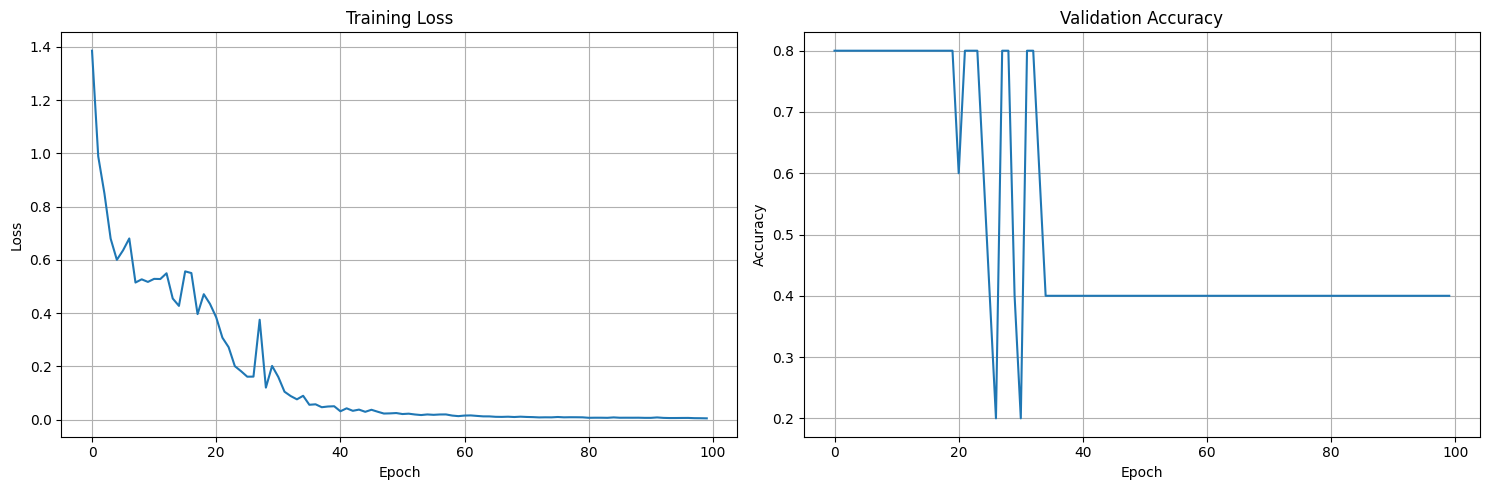

In [90]:
import matplotlib.pyplot as plt
# Graficar los valores de loss y accuracy
plt.figure(figsize=(15, 5))

# Graficar la loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Graficar la precisión de validación
plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [92]:
#guardar el modelo

model.bert.save_pretrained("/content/drive/MyDrive/model/text_classifierM-100-1epoch")
tokenizer.save_pretrained("/content/drive/MyDrive/model/text_classifierT-100-1epoch")


('/content/drive/MyDrive/model/text_classifierT-100-1epoch/tokenizer_config.json',
 '/content/drive/MyDrive/model/text_classifierT-100-1epoch/special_tokens_map.json',
 '/content/drive/MyDrive/model/text_classifierT-100-1epoch/vocab.txt',
 '/content/drive/MyDrive/model/text_classifierT-100-1epoch/added_tokens.json',
 '/content/drive/MyDrive/model/text_classifierT-100-1epoch/tokenizer.json')

In [93]:
#hacer predicciones

from transformers import pipeline

# Cargar el modelo guardado
classifier = pipeline("text-classification", model="/content/drive/MyDrive/model/text_classifierM-100-1epoch", tokenizer="/content/drive/MyDrive/model/text_classifierT-100-1epoch", device=0)

# Clasificar nuevos textos
new_texts = [
    "politicas academicas, Aprobar el Reglamento de Viajes de Estudio que enmarca las actividades de complementación de la formación profesional",
    "Este documento describe procesos administrativos internos."
]
predictions = classifier(new_texts)
print(predictions)


[{'label': 'LABEL_4', 'score': 0.9425507187843323}, {'label': 'LABEL_4', 'score': 0.9763853549957275}]


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
